# Molecular docking

This is the main protocol of Jupyter Dock.

## Content of this notebook

1. Feching system and cleanup
2. Protein and ligand sanitization
3. System Visualization 
4. Docking with AutoDock Vina
    - Receptor preparation
    - Ligand preparation
    - Docking box definition
    - Docking
    - PDBQT results file conversion to SDF
    - 3D visualization of docking results
    - 2D interaction table and map
5. Docking with Smina
    - Receptor preparation
    - Ligand preparation
    - Docking box definition
    - Docking
    - 3D visualization of docking results
    - 2D interaction table and map

It's a good idea to run the test protocols before attempting custom projects. Later, the user can specify the location of his/her project and save all of the files separately.

## 1. Feching system and cleanup

Implementing NGL View is a simple way to download PDB structures. The user can launch this or any other Jupyter Dock's protocol by providing his or her own files.

In [ ]:
import nglview as nv
import MDAnalysis as mda
from MDAnalysis.tests.datafiles import PDB_full  # use your own PDB file or fetch one
from Bio.PDB import PDBList
import subprocess
import requests

pdbl = PDBList()
pdbl.retrieve_pdb_file('{PDB_INPUT}', file_format='mmCif', pdir='.')

# save the output of the request to a file
with open("{PDB_INPUT}.pdb", "wb") as file:
    file.write(requests.get("https://files.rcsb.org/download/{PDB_INPUT}.pdb").content)

# Load structure
u = mda.Universe("{PDB_INPUT}.pdb")  # Download this beforehand using Biopython or RCSB

# Select protein and ligand
protein = u.select_atoms("protein")
ligand = u.select_atoms("not protein and not resname HOH WAT TIP3")  # Typically organic or HETATM

# Save selections
protein.write("{PDB_INPUT}_clean_H.pdb")
ligand.write("{PDB_INPUT}_lig.pdb")  # or use `ligand.write("{PDB_INPUT}_lig.mol2")` with openbabel support
subprocess.run(["obabel", "{PDB_INPUT}_lig.pdb", "-O", "{PDB_INPUT}_ligand.mol2"], check=True)

# Visualize
view = nv.show_mdanalysis(u)
view.clear_representations()
view.add_cartoon(selection="protein")
view.add_ball_and_stick(selection="not protein and not water")
view

#### Method 1: fix_protein (PDBFixer)

For proteins with missing amino acids or residues, or to ensure a more thorough sanitization of protein Jupyter Dock includes the _fix_protein()_ function, which employs PDBFixer to correct a wide range of common errors in protein pdb files. Furthermore, PDBFixer enables the assignment of pH-dependent protonation states to proteins.


>**Hint:** PDBFixer is a great solution for many systems because it can solve serious problems in PDB files. As a result, PDBFixer renumbers the residues beginning with 1 regardless of the numbering on the original PDB file. To address this issue, the **_fix_protein()_** function includes a protocol for atomically renumbering the residues in accordance with the original PDB file.


**_fix_protein ( params )_**

Params:
      
  - **filename**: _str or path-like_ ; input file containing protein struture to be modified, file extrension must be pdb

  - **addHs_pH**: _float_ ; Add hydrogens at user defined pH

  - **try_renumberResidues**: _bool_ ; By default PDBFixer renumarets residues starting in 1, this option tries to recover originar residues numbering
    
  - **output**: _str or path-like_ ; output filename, extension must be pdb

```
fix_protein(filename='{PDB_INPUT}_clean_H.pdb',addHs_pH=7.4,try_renumberResidues=True,output='{PDB_INPUT}_clean_H.pdb')
```

In [65]:
from pdbfixer import PDBFixer
from openmm.app import PDBFile
from MDAnalysis.coordinates import PDB

def fix_protein(filename='',addHs_pH=7.4,output='',try_renumberResidues=False):

    fix = PDBFixer(filename=filename)
    fix.findMissingResidues()
    fix.findNonstandardResidues()
    fix.replaceNonstandardResidues()
    fix.removeHeterogens(True)
    fix.findMissingAtoms()
    fix.addMissingAtoms()
    fix.addMissingHydrogens(addHs_pH)
    PDBFile.writeFile(fix.topology, fix.positions, open(output, 'w'))

    if try_renumberResidues == True:
        try:
            original=mda.Universe(filename)
            from_fix=mda.Universe(output)

            resNum=[res.resid for res in original.residues]
            for idx,res in enumerate(from_fix.residues):
                res.resid = resNum[idx]

            save=PDB.PDBWriter(filename=output)
            save.write(from_fix)
            save.close()
        except Exception:
            print('Not possible to renumber residues, check excepton for extra details')


In [66]:
fix_protein(filename='{PDB_INPUT}_clean_H.pdb', output='{PDB_INPUT}_fixed.pdb', try_renumberResidues=True)

/Users/jessicatan/miniconda3/envs/Jupyter_Dock/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:1129: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"


### 2.2. Ligand sanitization

Due to the variability of ligands and formats, ligand sanitization and preparation can be one of the most difficult tasks to complete. Setting protonation states for a ligand, for example, can be difficult. It is highly recommended that the user knows and understands the proper states for his/her ligand(s) when using Jupyter Dock or any other molecular docking approach.

[16:38:44] {PDB_INPUT}_lig.pdb: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.


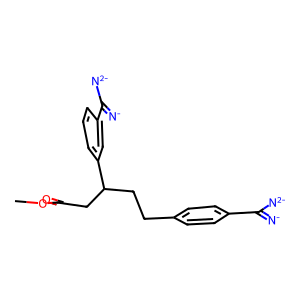

In [67]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw

m=Chem.MolFromMol2File('{PDB_INPUT}_ligand.mol2',sanitize=False)
Draw.MolToImage(m)

The end result of ligand sanitization is a new molecule that RDKit can display without having to use the sanitization parameter. Furthermore, the output structure for this example corresponds exactly to the one reported in the PDB database (PDB {PDB_INPUT})

## 3. System Visualization

A cool feature of Jupyter Dock is the posibility of visualize ligand-protein complexes and docking results into the notebbok. All this thanks to the powerful py3Dmol. 

Now the protein and ligand have been sanitized it would be recomended to vissualize the ligand-protein reference system.

In [68]:
view = nv.NGLWidget()
view.add_component("{PDB_INPUT}_clean_H.pdb")
view.clear_representations()
view.add_cartoon(color='white')
view.add_surface(opacity=0.6, color='white')

view.add_component("{PDB_INPUT}_ligand.mol2")
view.add_representation("ball+stick", selection="all", color_scheme="greenCarbon", radius=0.2)
view.center()
view

NGLWidget()

## 4. Docking with AutoDock Vina

AutoDock Vina (Vina) is one of the docking engines in the AutoDock Suite, together with AutoDock4 (AD4), AutoDockGPU, AutoDockFR, and AutoDock-CrankPep, and arguably among the most widely used and successful docking engines. The reasons for this success are mostly due to its ease of use and its speed (up to 100x faster than AD4), when compared to the other docking engines in the suite and elsewhere, as well as being open source.

### 4.1. Protein preparation

After sanitization, the protein docking preparation includes converting it to the PDBQT file format, which stores the atomic coordinates, partial charges, and AutoDock atom types for both the receptor and the ligand. 

>**Hint:** Despite the fact that the PDBQT format includes changes (Q) and atom types (T) for molecular docking. The charges are not required for Autodock Vina, which computes electrostatic interactions using its own force field. Although, when using AutoDock instead of AutoDock Vina, the Q term is required. More information can be found here:https://autodock-vina.readthedocs.io/en/latest/introduction.html

#### Method 1: AutoDock Tools prepare_receptor

The AutoDock Tools are the best way to prepare the receptor for AutoDock Vina. Nonetheless, AutoDock Tools is a comprehensive suite of programs and scripts that are difficult to manage. Jupyter Dock execute the **_prepare receptor_** and **_prepare_ligand_** functions on their own. As a result, obtaining proper PDBQT files for AutoDock Vina has never been easier.

>**Warning:** There is currently only one method for preparing a PDBQT file for a receptor. It is expected that new methods apart from AutoDock Tools executables will be included in the near future into Jupyter Dock.

In [69]:
!./bin/prepare_receptor #Lauch this cell to see parameters

./bin/prepare_receptor: line 15: /Users/jessicatan/Downloads/ADFRsuite_x86_64Darwin_1.0: is a directory
prepare_receptor4: receptor filename must be specified.
Usage: prepare_receptor4.py -r filename

    Description of command...
         -r   receptor_filename 
        supported file types include pdb,mol2,pdbq,pdbqs,pdbqt, possibly pqr,cif
    Optional parameters:
        [-v]  verbose output (default is minimal output)
        [-o pdbqt_filename]  (default is 'molecule_name.pdbqt')
        [-A]  type(s) of repairs to make: 
             'bonds_hydrogens': build bonds and add hydrogens 
             'bonds': build a single bond from each atom with no bonds to its closest neighbor
             'hydrogens': add hydrogens
             'checkhydrogens': add hydrogens only if there are none already
             'None': do not make any repairs 
             (default is 'None')
        [-C]  preserve all input charges ie do not add new charges 
             (default is addition of gasteige

In [70]:
!./bin/prepare_receptor -v -r {'{PDB_INPUT}_clean_H.pdb'} -o {'{PDB_INPUT}_clean_H.pdbqt'}

./bin/prepare_receptor: line 15: /Users/jessicatan/Downloads/ADFRsuite_x86_64Darwin_1.0: is a directory
set verbose to  True
set receptor_filename to  {PDB_INPUT}_clean_H.pdb
set outputfilename to  {PDB_INPUT}_clean_H.pdbqt
read  {PDB_INPUT}_clean_H.pdb
setting up RPO with mode= automatic and outputfilename=  {PDB_INPUT}_clean_H.pdbqt
charges_to_add= gasteiger
delete_single_nonstd_residues= None
adding gasteiger charges to peptide


### 4.2. Ligand preparation

As previously discussed, one of the major challenges for proper docking experimentation is ligand preparation.

>**Hint:** The hydroges in this example were set during the ligand sanitization step (section 2.2). As a result, the ligand will be prepared as is. Furthermore, before running the docking, it is highly recommended to inspect the ligand(s) after preparation to ensure proper structure and molecule features.

#### Method 1: AutoDock Tools prepare_ligand

In [71]:
!./bin/prepare_ligand #Launch this cell to see parameters

./bin/prepare_ligand: line 15: /Users/jessicatan/Downloads/ADFRsuite_x86_64Darwin_1.0: is a directory
prepare_ligand4: ligand filename must be specified.
Usage: prepare_ligand4.py -l filename

    Description of command...
         -l     ligand_filename (.pdb or .mol2 or .pdbq format)
    Optional parameters:
        [-v]    verbose output
        [-o pdbqt_filename] (default output filename is ligand_filename_stem + .pdbqt)
        [-d]    dictionary to write types list and number of active torsions 
        [-A]    type(s) of repairs to make:
		 bonds_hydrogens, bonds, hydrogens (default is to do no repairs)
        [-C]    do not add charges (default is to add gasteiger charges)
        [-p]    preserve input charges on an atom type, eg -p Zn
               (default is not to preserve charges on any specific atom type)
        [-U]    cleanup type:
		 nphs_lps, nphs, lps, '' (default is 'nphs_lps') 
        [-B]    type(s) of bonds to allow to rotate 
               (default sets '

In [72]:
!./bin/prepare_ligand -v -l {'{PDB_INPUT}_ligand.mol2'} -o {'{PDB_INPUT}_lig_H.pdbqt'}

./bin/prepare_ligand: line 15: /Users/jessicatan/Downloads/ADFRsuite_x86_64Darwin_1.0: is a directory
set verbose to  True
set ligand_filename to  {PDB_INPUT}_ligand.mol2
set outputfilename to  {PDB_INPUT}_lig_H.pdbqt
read  {PDB_INPUT}_ligand.mol2
setting up LPO with mode= automatic and outputfilename=  {PDB_INPUT}_lig_H.pdbqt
and check_for_fragments= False
and bonds_to_inactivate= 
returning  0
No change in atomic coordinates


### 4.3. Box Definition Using NGLView and MDAnalysis
This is possibly the most important feature of Jupyter Dock. Making a docking box without the use of a visualizer or any other additional tools. With the integration of NGLView for visualization and MDAnalysis for atom selection and coordinate manipulation, it's now possible to compute and visualize bounding boxes entirely in Python.

**Hint** Defining the Box
MDAnalysis allows you to select atoms based on flexible selection queries. You can define a bounding box around:
- a ligand (resname LIG)
- a specific residue (resid 123)
- a protein domain (protein and name CA)
- or any complex selection using the MDAnalysis selection syntax

Once you've selected the atoms, you can compute the minimum and maximum coordinates to define the corners of the box.

In [73]:
import nglview as nv
import MDAnalysis as mda
import numpy as np

# Load structures
lig_u = mda.Universe('{PDB_INPUT}_ligand.mol2')
lig = lig_u.atoms

# Compute bounding box
coords = lig.positions  # shape (N,3)
ext = 5.0
min_c, max_c = coords.min(axis=0) - ext, coords.max(axis=0) + ext
center = ((min_c + max_c) / 2).tolist()
size = (max_c - min_c).tolist()

# Setup viewer
view = nv.NGLWidget()
view.add_component('{PDB_INPUT}_clean_H.pdb')  # protein
view.add_component('{PDB_INPUT}_ligand.mol2')   # ligand
view.center(component=1)

# Clear and print values
view.clear()
print("Center:", center)
print("Size:", size)


Center: [31.600500106811523, 13.32800006866455, 16.96150016784668]
Size: [23.12099838256836, 17.302000045776367, 15.529000282287598]


### 4.4. Docking 

AutoDock Vina 1.2.0, which was recently released, now allows AutoDock Vina to be executed using Python Bindings. Jupyter Dock takes advantage of this feature to make the docking protocol run entirely within a Jupyter notebook.

In [74]:
from vina import Vina

v = Vina(sf_name='vina')

v.set_receptor('{PDB_INPUT}_clean_H.pdbqt')

v.set_ligand_from_file('{PDB_INPUT}_lig_H.pdbqt')

v.compute_vina_maps(center=[center[0], center[1], center[2]], 
                    box_size=[size[0], size[1], size[2]])

'''
# Score the current pose
energy = v.score()
print('Score before minimization: %.3f (kcal/mol)' % energy[0])

# Minimized locally the current pose
energy_minimized = v.optimize()
print('Score after minimization : %.3f (kcal/mol)' % energy_minimized[0])
v.write_pose('1iep_ligand_minimized.pdbqt', overwrite=True)
'''

# Dock the ligand
v.dock(exhaustiveness=10, n_poses=10)
v.write_poses('{PDB_INPUT}_lig_vina_out.pdbqt', n_poses=10, overwrite=True)

Computing Vina grid ... done.
Performing docking (random seed: -1117550632) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -6.407          0          0
   2       -6.398     0.2735      1.304
   3       -6.181      2.667      3.969
   4       -6.031      1.562      2.295
   5       -6.015      3.783      5.146
   6       -5.948      2.237      6.864
   7       -5.889      4.073      6.404
   8       -5.822      3.655      6.654
   9       -5.788      2.842       3.92
  10       -5.751      3.881      6.167


### 4.5. PDBQT results file conversion to SDF

Because of the unique characteristics of the PDBQT format, it may be difficult to visualize the results or perform other analyses after docking. As a result, Jupyter Dock automatically converts the PDFBQT format to the more common SDF format. The file conversion preserves the chemical properties of the compounds after they have been sanitized and prepared. Furthermore, the "Pose" and "Score" information is saved as a molecule attribute. Such data can be accessed directly in the file or via Pybel or RDKit.

**_pdbqt_to_sdf ( params )_**

params:

- **pdbqt_file**: _str or path-like string_ ; pdbqt file to be converted, extension must be pdbqt
- **output**: _str or path-like string_  ; output sdf file, extension must be sdf

In [75]:
from openbabel import pybel

def pdbqt_to_sdf(pdbqt_file=None,output=None):
    results = [m for m in pybel.readfile(filename=pdbqt_file,format='pdbqt')]
    out=pybel.Outputfile(filename=output,format='sdf',overwrite=True)
    for pose in results:

        pose.data.update({'Pose':pose.data['MODEL']})
        pose.data.update({'Score':pose.data['REMARK'].split()[2]})
        del pose.data['MODEL'], pose.data['REMARK'], pose.data['TORSDO']

        out.write(pose)
    out.close()

pdbqt_to_sdf(pdbqt_file='{PDB_INPUT}_lig_vina_out.pdbqt',output='{PDB_INPUT}_lig_vina_out.sdf')

### 4.6. 3D visualization of docking results (AutoDock Vina)

As with the system visualization (section 3), the docking results can be inspected and compared to the reference structure (if exist). The ligand's "Pose" and "Score" information will also be displayed to show how acces to this molecule's attributes.

In [76]:
import nglview as nv
from rdkit import Chem
from rdkit.Chem import AllChem
import tempfile

# Load protein (white cartoon with surface)
prot_view = nv.show_file("{PDB_INPUT}_clean_H.pdb")
prot_view.clear()
prot_view.add_cartoon(color="white")
prot_view.add_surface(opacity=0.6, color="white")
prot_view.background = "black"  # emulate outline style in py3Dmol

# Load reference ligand (magenta sticks)
ref_view = nv.show_file("{PDB_INPUT}_ligand.mol2")
ref_view.clear()
ref_view.add_representation("licorice", color="magenta")

# Load Vina pose from SDF (cyan sticks)
results = Chem.SDMolSupplier('{PDB_INPUT}_lig_vina_out.sdf')
vina_pose = results[0]

# Write mol to temp file for NGLView
with tempfile.NamedTemporaryFile(suffix=".mol", mode="w", delete=False) as temp_mol_file:
    mol_block = Chem.MolToMolBlock(vina_pose)
    temp_mol_file.write(mol_block)
    vina_pose_path = temp_mol_file.name

vina_view = nv.show_file(vina_pose_path)
vina_view.clear()
vina_view.add_representation("licorice", color="cyan")

# Combine all views
view = nv.NGLWidget()
view.add_component("{PDB_INPUT}_clean_H.pdb")     # Protein
view.add_cartoon(color="white")
view.add_surface(opacity=0.6, color="white")

view.add_component("{PDB_INPUT}_ligand.mol2")      # Reference ligand
view.add_representation("licorice", color="magenta")

view.add_component(vina_pose_path)         # Vina pose
view.add_representation("licorice", color="cyan")

# Finish setup
view.center()
view.background = "black"

# Show view
view


NGLWidget(background='black')

### 4.7. 2D interaction table and map

Inspecting the molecular interactions is one of the most common analyses performed by a computational scientist following a docking experiment. As a result, Jupyter Dock uses ProLif to create a table of ligand-protein molecular interactions as well as the corresponding 2D map.

>**Info:** ProLif uses RDKit and MDAnalysis to map the molecular interaction between a ligand and a protein. As a result, some protein preparations, including the use of LePro, can result in errors that impede analysis. Jupyter Dock's _**fix protein()_** function can be used to avoid such errors and provide a suitable protein structure for the analysis.

In [ ]:
fix_protein(filename='{PDB_INPUT}_clean_H.pdb',addHs_pH=7.4,try_renumberResidues=True,output='{PDB_INPUT}_clean_H_fix.pdb')

In [78]:
import MDAnalysis as mda
import prolif as plf

# Load protein
prot = mda.Universe("{PDB_INPUT}_clean_H_fix.pdb")
prot = plf.Molecule.from_mda(prot)
print(f"Protein has {prot.n_residues} residues")

# Load ligands
lig_suppl = plf.sdf_supplier('{PDB_INPUT}_lig_vina_out.sdf')

# Generate fingerprint
fp = plf.Fingerprint()
fp.run_from_iterable(lig_suppl, prot)

# Convert to DataFrame
results_df = fp.to_dataframe()
results_df

Protein has 223 residues


  0%|          | 0/10 [00:00<?, ?it/s]

ligand            UNL1           
protein       SER195.A   GLY216.A
interaction VdWContact VdWContact
Frame                            
0                 True      False
1                 True      False
2                False      False
3                 True      False
4                False      False
5                False      False
6                 True      False
7                False      False
8                False       True
9                False      False

In [82]:
from prolif.plotting.network import LigNetwork

net = LigNetwork.from_fingerprint(
    fp,                                
    lig_suppl[0],                      
    kind="frame",                      
    frame=0,                           
    rotation=270                      
)

net.display()


## 5. Docking with Smina

Despite the presence of Python bindings in AutoDock Vina 1.2.0, other tools that incorporate AutoDock Vina allow for cool features such as custom score functions (smina), fast execution (qvina), and the use of wider boxes (qvina-w). Jupyter Dock can run such binaries in a notebook, giving users more options.

Smina is a fork of AutoDock Vina that is customized to better support scoring function development and high-performance energy minimization. Smina is maintained by David Koes at the University of Pittsburgh and is not directly affiliated with the AutoDock project.

>**Info:** The following cell contains an example of using Smina to run the current docking example. However, the executable files for qvina and qvina-w are available in the Jupyter Dock repo's bin directory. As a result, the user can use such a tool by adding the necessary cells or replacing the current docking engine.

### 5.1. Receptor preparation

Despite the fact that Smina is a modified version of AutoDock Vina, the input file for a receptor in Smina can be either a PDBQT file or a PDB file with explicit hydrogens in all residues. At this point, we can make use of the file sanitization steps as well as a protein structure from Jupyter Dock's _**fix_protein()**_ function.

### 5.2. Ligand preparation

In Smina, we can use any OpenBabel format for ligand input and docking results, just like we can for receptor preparation. As a result, after sanitization, we can use the ligand MOL2 file here. 

### 5.3. Docking box definition

This step can be completed in the same manner as the AutoDock Vina box definition.

### 5.4. Docking

Jupyter Dock comes with the smina executable for Linux and Mac OS. By running the binary file, the parameters can be accessed.

In [86]:
!./bin/smina.osx

Missing receptor.

Correct usage:

Input:
  -r [ --receptor ] arg         rigid part of the receptor (PDBQT)
  --flex arg                    flexible side chains, if any (PDBQT)
  -l [ --ligand ] arg           ligand(s)
  --flexres arg                 flexible side chains specified by comma 
                                separated list of chain:resid or 
                                chain:resid:icode
  --flexdist_ligand arg         Ligand to use for flexdist
  --flexdist arg                set all side chains within specified distance 
                                to flexdist_ligand to flexible

Search space (required):
  --center_x arg                X coordinate of the center
  --center_y arg                Y coordinate of the center
  --center_z arg                Z coordinate of the center
  --size_x arg                  size in the X dimension (Angstroms)
  --size_y arg                  size in the Y dimension (Angstroms)
  --size_z arg                  size in the Z dimen

In [91]:
!./bin/smina.osx -r {'{PDB_INPUT}_clean_H.pdb'} -l {'{PDB_INPUT}_ligand.mol2'} -o {'{PDB_INPUT}_lig_smina_out.sdf'} --center_x 31.859 --center_y 13.34 --center_z 17.065 --size_x 24.569 --size_y 18.12 --size_z 17.37 --exhaustiveness 8 --num_modes 10

   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___  |
        ) || |   | |   | |   | | \   || (   ) |
  /\____) || )   ( |___) (___| )  \  || )   ( |
  \_______)|/     \|\_______/|/    )_)|/     \|


smina is based off AutoDock Vina. Please cite appropriately.

Weights      Terms
-0.035579    gauss(o=0,_w=0.5,_c=8)
-0.005156    gauss(o=3,_w=2,_c=8)
0.840245     repulsion(o=0,_c=8)
-0.035069    hydrophobic(g=0.5,_b=1.5,_c=8)
-0.587439    non_dir_h_bond(g=-0.7,_b=0,_c=8)
1.923        num_tors_div

Using random seed: -1103882010

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------

### 5.6. 3D visualization of docking results

As with the system visualization (section 3), the docking results can be inspected and compared to the reference structure (if one exists). Smina saves the "minimizedAffinity" information corresponding to the docking score as the molecule's attribute.

In [93]:
import nglview as nv
from rdkit import Chem
from rdkit.Chem import AllChem
from openbabel import openbabel
import tempfile

# Load protein
protein_view = nv.show_file("{PDB_INPUT}_clean_H.pdb")
protein_view.clear_representations()
protein_view.add_representation("cartoon", color="white")
protein_view.add_surface(opacity=0.6, color="white")

# Load ligand from MOL2
ligand_view = nv.show_file("{PDB_INPUT}_ligand.mol2")
ligand_view.clear_representations()
ligand_view.add_representation("ball+stick", color_scheme="element", radius=0.2)

# Load Smina pose from SDF using RDKit
results = Chem.SDMolSupplier('{PDB_INPUT}_lig_smina_out.sdf')
pose = results[0]
affinity = pose.GetProp('minimizedAffinity')
print('Reference: Magenta | Smina Pose: Cyan')
print(f'Score: {affinity}')

# Write Smina pose to temporary MOL2 file to use with nglview
with tempfile.NamedTemporaryFile(delete=False, suffix=".mol2", mode='w') as f:
    f.write(Chem.MolToMolBlock(pose))
    pose_filename = f.name

pose_view = nv.show_file(pose_filename)
pose_view.clear_representations()
pose_view.add_representation("ball+stick", color_scheme="cyanCarbon", radius=0.2)

# Combine all views into one
view = nv.NGLWidget()
view.add_component("{PDB_INPUT}_clean_H.pdb")
view[0].clear_representations()
view[0].add_representation("cartoon", color="white")
view[0].add_surface(opacity=0.6, color="white")

view.add_component("{PDB_INPUT}_ligand.mol2")
view[1].clear_representations()
view[1].add_representation("ball+stick", color_scheme="magentaCarbon", radius=0.2)

view.add_component(pose_filename)
view[2].clear_representations()
view[2].add_representation("ball+stick", color_scheme="cyanCarbon", radius=0.2)

view.center()
view

Reference: Magenta | Smina Pose: Cyan
Score: -8.23396


[16:48:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


NGLWidget()

### 5.7. 2D interaction table and map

Inspecting the molecular interactions is one of the most common analyses performed by a computational scientist following a docking experiment. As a result, Jupyter Dock uses ProLif to create a table of ligand-protein molecular interactions as well as the corresponding 2D map.

>**Info:** ProLif uses RDKit and MDAnalysis to map the molecular interaction between a ligand and a protein. As a result, some protein preparations, including the use of LePro, can result in errors that impede analysis. Jupyter Dock's _**fix protein()_** function can be used to avoid such errors and provide a suitable protein structure for the analysis.

In [95]:
# load protein
prot = mda.Universe("{PDB_INPUT}_clean_H_fix.pdb")
prot = plf.Molecule.from_mda(prot)
prot.n_residues

# load ligands
lig_suppl = list(plf.sdf_supplier('{PDB_INPUT}_lig_smina_out.sdf'))
# generate fingerprint
fp = plf.Fingerprint()
fp.run_from_iterable(lig_suppl, prot)
results_df = fp.to_dataframe()
results_df

[16:49:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[16:49:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[16:49:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[16:49:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[16:49:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[16:49:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[16:49:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[16:49:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[16:49:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

  0%|          | 0/10 [00:00<?, ?it/s]

ligand            UNL1                                                      
protein       ASN143.A   GLY148.A ASP189.A              SER195.A GLY216.A   
interaction VdWContact VdWContact  HBDonor VdWContact VdWContact  HBDonor   
Frame                                                                       
0                 True      False    False       True      False    False  \
1                 True       True     True       True      False    False   
2                False      False    False      False      False    False   
3                False      False     True       True      False    False   
4                False      False    False       True       True    False   
5                False      False     True       True       True    False   
6                False      False    False       True      False    False   
7                False      False    False      False       True    False   
8                False      False    False      False       True     True   
9                False      False    False      False      False    False   

ligand                                      
protein                GLY219.A             
interaction VdWContact  HBDonor VdWContact  
Frame                                       
0                False     True       True  
1                False     True       True  
2                False     True       True  
3                False     True       True  
4                 True     True       True  
5                False     True       True  
6                False     True       True  
7                False    False      False  
8                 True    False      False  
9                False    False      False

In [97]:
net = LigNetwork.from_fingerprint(
    fp,                                
    lig_suppl[0],                      
    kind="frame",                      
    frame=0,                           
    rotation=270                      
)

net.display()